<a href="https://colab.research.google.com/github/hsanchez/colabs/blob/main/wlk/Weisfeiler_Lehman_Neural_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weisfeiler-Lehman Neural Machine for Link Prediction

## Paper summary

There are many times when want to predict
whether a link will exist between two nodes in a graph.

In social networks, we want to predict whether two
people will become friends.... in user-project networks 
where we want to recommend products to users ... Or
in API call prediction where want to recommend APIs to developers.

Currently, most solutions are heuristic based solutions; e.g., 
1. The common neighbors (CN) heuristic where
   we calculate some node proximity score to generate a link; e.g., given two 
   nodes x and y, we say that x and y are likely to have 
   a link if they have many common neighbors
2. The preferential-attachment heuristic where we predict
   links using the product of number of degrees; e.g., x
   prefers to connect to y if y is popular.
3. and more

The problems of heuristics methods:

1. They have strong assumptions about link formation (too rigid),
2. They can been seen as some handcrafted graph features

_Can we automatically learn such features from the network?_

The Weisfeiler-Lehman Neural Machine uses neural networks to 
automatically learn graph features for link prediction.
This approach is the first deep learning approach (not by embedding)
for link prediction:

Given a link L = (x, y), (1) we extract its local neighborhood subgraph as the data
representation for L by adding L's 1-hop neighbors, 2-hop neigbors, and so forth. We do
this iteratively in other to extract this subgraph, which represents the local subgraph
pattern of a link. (2) We transform the subgraph into a vector by performing graph
labeling to determine vertex ordering, and then construct an adjancency matrix, which we
vertically feed it into neural network.

```
@inproceedings{zhang2017weisfeiler,
  title={Weisfeiler-lehman neural machine for link prediction},
  author={Zhang, Muhan and Chen, Yixin},
  booktitle={Proceedings of the 23rd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining},
  pages={575--583},
  year={2017}
}
```


## Importing the library

In [5]:
import networkx as nx
import scipy.sparse
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import pandas as pd
import subprocess
import os

## Importing the dataset

In [6]:
# download mat file from its home at GitHub
FILENAME = 'USAir.mat'
if not os.path.exists(f'{FILENAME}'):
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1yyDyrxlIj51BFVnj0Xuz2sglbHqk1mjm' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1yyDyrxlIj51BFVnj0Xuz2sglbHqk1mjm" -O 'USAir.mat' && rm -rf /tmp/cookies.txt
else:
  print(f"{FILENAME} does exist!")


USAir.mat does exist!


In [7]:
data = loadmat(f'./{FILENAME}')

In [8]:
data

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Oct 20 12:21:53 2016',
 '__version__': '1.0',
 'net': <332x332 sparse matrix of type '<class 'numpy.float64'>'
 	with 4252 stored elements in Compressed Sparse Column format>}

## Create a graph from the adjacency matrix

In [9]:
network = nx.from_numpy_matrix(data['net'].todense())

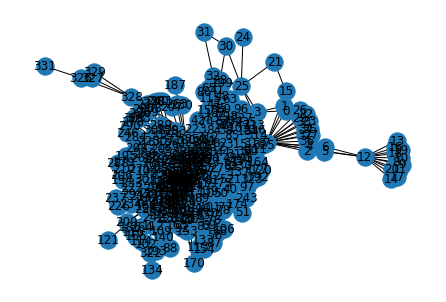

In [10]:
nx.draw(network, with_labels = True)

In [11]:
shape = network.number_of_nodes(), network.number_of_edges()
shape

(332, 2126)

## Dividing the network into the training and test networks

In [12]:
network_train = network.copy()
network_test = nx.empty_graph(network_train.number_of_nodes())

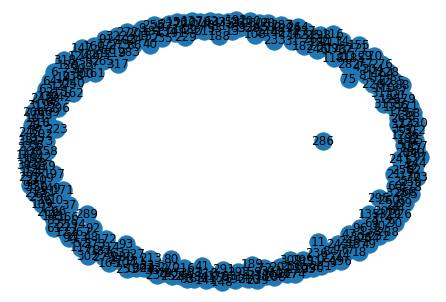

In [13]:
# empty graph: G = (N number of nodes, 0 edges)
nx.draw(network_test, with_labels = True)

In [14]:
# training and testing links given a test ratio
test_ratio = 0.1
n_links = network_train.number_of_edges()
n_links_test = math.ceil(test_ratio * n_links)

In [15]:
n_links, n_links_test

(2126, 213)

In [16]:
selected_links_id = np.random.choice(np.arange(n_links), size=n_links_test, replace=False)
selected_links_id

array([1672, 1820,    8, 2029,  957,  890, 1657, 1077, 1997,  824,  277,
        442,   38,  946, 1983,  167, 1227, 1565, 1172,  133, 1072,  992,
       1854,  259, 1886,  387, 1028, 1279,  432, 1825,  107,   78,  694,
       1244, 1909, 1682,  306,  877,  850,  788, 1914,  727, 1990, 1698,
        325, 1319, 2123,  534, 1904, 1371, 1833,  976,  657,  667, 1048,
        831, 1778, 1627, 1026, 1855, 1848, 1423,  344, 1569, 1380, 2020,
        462,  551, 1237,  980, 1699, 1805,   36, 1787, 1216, 1329,   79,
        130, 1144, 1633,  251, 2088,  207,  949, 1942, 1082,  912,  579,
       1112,  611, 1503,  828,   81, 1488,   13,  765, 1148,  712,  195,
       1190,  665,  653,  873,  726, 1989,  437, 2004,   70, 1273,  819,
        246,  257, 1993, 2092, 1417, 1979,  339,  450,  237, 1701,  460,
       1685,  720,  848,  812, 1270, 1241, 1733,  532, 1881, 1385,  223,
       2097,  508, 1438,  806,  718,  840,  640, 1419, 2002,   62,  363,
        977, 1161, 1143,  333,  743,  923,  425, 18

In [17]:
# Return the upper triangular portion of a matrix in sparse format
# whose values are non zero
network_adj_matrix = nx.adjacency_matrix(network)
network_adj_matrix = scipy.sparse.triu(network_adj_matrix, k=1)
row_index, col_index = network_adj_matrix.nonzero()
links = [(x, y) for x, y in zip(row_index, col_index)]
len(links)

2126

In [18]:
# train and testing sets of links
selected_links = []
for link_id in selected_links_id:
    selected_links.append(links[link_id])
network_train.remove_edges_from(selected_links)
network_test.add_edges_from(selected_links)

In [19]:
network_train.number_of_edges(), network_test.number_of_edges()

(1913, 213)

## Sampling negative links

Recall that positive links are all edges $e \in E$, whereas 
negative links are those pairs of $x, y \in V \notin E$.   
Here, we will select all positive links and then randomly select $k|E|$ negative samples.

In [20]:
k = 2
n_links_train_pos = network_train.number_of_edges()
n_links_test_pos = network_test.number_of_edges()
n_links_train_neg = k * n_links_train_pos
n_links_test_neg = k * n_links_test_pos

In [21]:
neg_network = nx.empty_graph(network.number_of_nodes())
links_neg = list(nx.non_edges(network))
neg_network.add_edges_from(links_neg)

In [22]:
n_links_neg = neg_network.number_of_edges()
n_links_neg

52820

In [23]:
selected_links_neg_id = np.random.choice(np.arange(n_links_neg), size=n_links_train_neg + n_links_test_neg, replace=False)
len(selected_links_neg_id)

4252

In [24]:
neg_network_train = nx.empty_graph(network.number_of_nodes())
neg_network_test = nx.empty_graph(network.number_of_nodes())

In [25]:
selected_links = []
for i in range(n_links_train_neg):
    link_id = selected_links_neg_id[i]
    selected_links.append(links_neg[link_id])
neg_network_train.add_edges_from(selected_links)

selected_links = []
for i in range(n_links_train_neg, n_links_train_neg + n_links_test_neg):
    link_id = selected_links_neg_id[i]
    selected_links.append(links_neg[link_id])
neg_network_test.add_edges_from(selected_links)

In [26]:
neg_network_train.number_of_nodes(), neg_network_test.number_of_nodes()

(332, 332)

In [27]:
neg_network_train.number_of_edges(), neg_network_test.number_of_edges()

(3826, 426)

## Grouping training and test links

In [28]:
all_links_train = list(network_train.edges) + list(neg_network_train.edges)
label_train = [1] * len(network_train.edges) + [0] * len(neg_network_train.edges)

In [29]:
all_links_test = list(network_test.edges) + list(neg_network_test.edges)
label_test = [1] * len(network_test.edges) + [0] * len(neg_network_test.edges)

In [30]:
y_train, y_test = np.array(label_train), np.array(label_test)

## Extracting enclosing subgraph for each links

In [31]:
link = all_links_train[12]
link

(6, 12)

In [32]:
fringe = [link]
subgraph = nx.Graph()

In [33]:
def enclosing_subgraph(fringe, network, subgraph, distance):
    neighbor_links = []
    for link in fringe:
        u = link[0]
        v = link[1]
        neighbor_links = neighbor_links + list(network.edges(u))
        neighbor_links = neighbor_links + list(network.edges(v))
    tmp_subgraph = subgraph.copy()
    tmp_subgraph.add_edges_from(neighbor_links)
    # Remove duplicate and _existed_ edge
    neighbor_links = [li for li in tmp_subgraph.edges() if li not in subgraph.edges()]
    tmp_subgraph = subgraph.copy()
    tmp_subgraph.add_edges_from(neighbor_links, distance=distance, inverse_distance=1/distance)
    return neighbor_links, tmp_subgraph

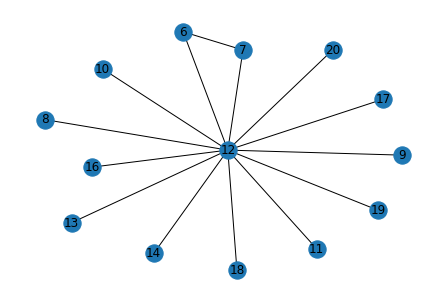

In [34]:
# 1-hop -> distance 1
fringe, subgraph = enclosing_subgraph(fringe, network_train, subgraph, distance=1)
nx.draw(subgraph, with_labels=True);

In [35]:
def extract_enclosing_subgraph(link, network, size=10):
    fringe = [link]
    subgraph = nx.Graph()
    distance = 0
    subgraph.add_edge(link[0], link[1], distance=distance)
    while subgraph.number_of_nodes() < size and len(fringe) > 0:
        distance += 1
        fringe, subgraph = enclosing_subgraph(fringe, network, subgraph, distance)
    
    tmp_subgraph = network.subgraph(subgraph.nodes)
    additional_edges = [li for li in tmp_subgraph.edges if li not in subgraph.edges]
    subgraph.add_edges_from(additional_edges, distance=distance+1, inverse_distance=1/(distance+1))
    return subgraph

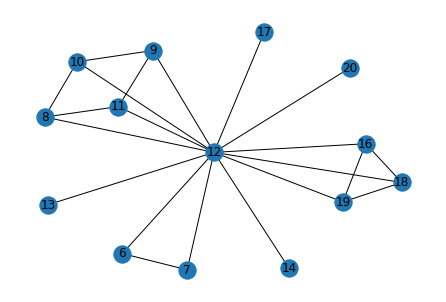

In [36]:
e_subgraph = extract_enclosing_subgraph(link, network_train)
nx.draw(e_subgraph, with_labels=True)

In [37]:
e_subgraph[6]

AtlasView({12: {'distance': 0}, 7: {'distance': 1, 'inverse_distance': 1.0}})

In [35]:
%%timeit
extract_enclosing_subgraph(link, network_train)

1000 loops, best of 5: 276 µs per loop


In [36]:
%%timeit
for link in all_links_train:
    e_subgraph = extract_enclosing_subgraph(link, network_train)

1 loop, best of 5: 26.2 s per loop


## Subgraph encoding
### Palette-WL for vertex ordering

In [38]:
def compute_geometric_mean_distance(subgraph, link):
    u = link[0]
    v = link[1]
    subgraph.remove_edge(u, v)
    
    n_nodes = subgraph.number_of_nodes()
    u_reachable = nx.descendants(subgraph, source=u)
    v_reachable = nx.descendants(subgraph, source=v)
#     print(u_reachable, v_reachable)
    for node in subgraph.nodes:
        distance_to_u = 0
        distance_to_v = 0
        if node != u:
            distance_to_u = nx.shortest_path_length(subgraph, source=node, target=u) if node in u_reachable else 2 ** n_nodes
        if node != v:
            distance_to_v = nx.shortest_path_length(subgraph, source=node, target=v) if node in v_reachable else 2 ** n_nodes
        subgraph.nodes[node]['avg_dist'] = math.sqrt(distance_to_u * distance_to_v)
    
    subgraph.add_edge(u, v, distance=0)
    
    return subgraph

In [39]:
e_subgraph = compute_geometric_mean_distance(e_subgraph, link)

In [40]:
avg_dist = nx.get_node_attributes(e_subgraph, 'avg_dist')
avg_dist

{6: 0.0,
 7: 1.0,
 8: 1.7320508075688772,
 9: 1.7320508075688772,
 10: 1.7320508075688772,
 11: 1.7320508075688772,
 12: 0.0,
 13: 1.7320508075688772,
 14: 1.7320508075688772,
 16: 1.7320508075688772,
 17: 1.7320508075688772,
 18: 1.7320508075688772,
 19: 1.7320508075688772,
 20: 1.7320508075688772}

In [41]:
def prime(x):
    if x < 2:
        return False
    if x == 2 or x == 3:
        return True
    for i in range(2, x):
        if x % i == 0:
            return False
    return True

In [42]:
prime_numbers = np.array([i for i in range (10000) if prime(i)], dtype=np.int)
prime_numbers

array([   2,    3,    5, ..., 9949, 9967, 9973])

In [43]:
prime_numbers.shape

(1229,)

In [44]:
def palette_wl(subgraph, link):
    tmp_subgraph = subgraph.copy()
    if tmp_subgraph.has_edge(link[0], link[1]):
        tmp_subgraph.remove_edge(link[0], link[1])
    avg_dist = nx.get_node_attributes(tmp_subgraph, 'avg_dist')
    
    df = pd.DataFrame.from_dict(avg_dist, orient='index', columns=['hash_value'])
    df = df.sort_index()
    df['order'] = df['hash_value'].rank(axis=0, method='min').astype(np.int)
    df['previous_order'] = np.zeros(df.shape[0], dtype=np.int)
    adj_matrix = nx.adjacency_matrix(tmp_subgraph, nodelist=sorted(tmp_subgraph.nodes)).todense()
    while any(df.order != df.previous_order):
        df['log_prime'] = np.log(prime_numbers[df['order'].values])
        total_log_primes = np.ceil(np.sum(df.log_prime.values))
        df['hash_value'] = adj_matrix * df.log_prime.values.reshape(-1, 1) / total_log_primes + df.order.values.reshape(-1, 1)
        df.previous_order = df.order
        df.order = df.hash_value.rank(axis=0, method='min').astype(np.int)
    nodelist = df.order.sort_values().index.values
    return nodelist

In [45]:
nodelist = palette_wl(e_subgraph, link)
nodelist

array([ 6, 12,  7, 13, 14, 17, 20,  8,  9, 10, 11, 16, 18, 19])

In [46]:
size = 10
if len(nodelist) > size:
    nodelist = nodelist[:size]
    e_subgraph = e_subgraph.subgraph(nodelist)
    nodelist = palette_wl(e_subgraph, link)

In [47]:
nodelist

array([ 6, 12,  7, 13, 14, 17, 20,  8,  9, 10])

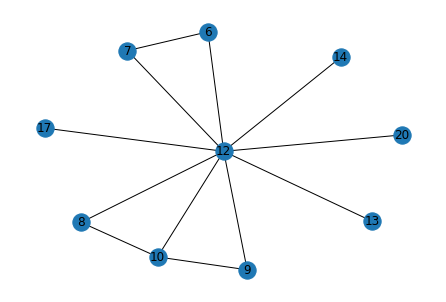

In [48]:
nx.draw(e_subgraph, with_labels=True);

In [49]:
e_subgraph.nodes[7]

{'avg_dist': 1.0}

### Represent enclosing subgraphs as adjacency matrices

In [50]:
def sample(subgraph, nodelist, weight='weight', size=10):
    adj_matrix = nx.adjacency_matrix(subgraph, weight=weight, nodelist=nodelist).todense()
    vector = np.asarray(adj_matrix)[np.triu_indices(len(adj_matrix), k=1)]
    d = size * (size - 1) // 2
    if len(vector) < d:
        vector = np.append(vector, np.zeros(d - len(vector)))
    return vector[1:]

In [51]:
sample(e_subgraph, nodelist, size=10)

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
      dtype=int64)

### Subgraph encoding test

In [52]:
link

(6, 12)

In [53]:
e_subgraph = extract_enclosing_subgraph(link, network_train, size=10)
e_subgraph = compute_geometric_mean_distance(e_subgraph, link)
nodelist = palette_wl(e_subgraph, link)
if len(nodelist) > size:
    nodelist = nodelist[:size]
    e_subgraph = e_subgraph.subgraph(nodelist)
    nodelist = palette_wl(e_subgraph, link)
embeded = sample(e_subgraph, nodelist, size=10)

In [54]:
embeded

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
      dtype=int64)

## Enclosing subgraph encoding for each links

In [55]:
def encode_link(link, network, weight='weight', size=10):
    e_subgraph = extract_enclosing_subgraph(link, network, size=size)
    e_subgraph = compute_geometric_mean_distance(e_subgraph, link)
    nodelist = palette_wl(e_subgraph, link)
    if len(nodelist) > size:
        nodelist = nodelist[:size]
        e_subgraph = e_subgraph.subgraph(nodelist)
        nodelist = palette_wl(e_subgraph, link)
    embeded_link = sample(e_subgraph, nodelist, weight=weight, size=size)
    return embeded_link

In [56]:
from functools import partial

In [56]:
%%timeit
np.array(list(map(partial(encode_link, network=network_train, weight='inverse_distance', size=10), all_links_train)))

1 loop, best of 5: 2min 39s per loop


In [57]:
X_train = np.array(list(map(partial(encode_link, network=network_train, weight='weight', size=10), all_links_train)))

In [58]:
X_train.shape

(5739, 44)

In [59]:
X_test = np.array(list(map(partial(encode_link, network=network_train, weight='weight', size=10), all_links_test)))

In [60]:
from sklearn.utils import shuffle
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)

In [61]:
X_train_shuffle.shape, y_train.shape

((5739, 44), (5739,))

## Neural Network Learning

In [62]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [63]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [67]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [94]:
mlp = MLPClassifier()
parameters = {
    'hidden_layer_sizes': [(32, 32, 16), (64, 32, 16), (64, 64, 16)],
    'activation': ['relu', 'tanh', 'logistic'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'alpha': [1e-3, 1e-6, 1e-9],
    'max_iter': [10, 50, 100],
    'tol': [0.0001, -10000]
}

cv = GridSearchCV(mlp, parameters, cv=5)
cv.fit(X_train_shuffle, y_train_shuffle)
print_results(cv)

BEST PARAMS: {'activation': 'tanh', 'alpha': 1e-09, 'hidden_layer_sizes': (64, 64, 16), 'learning_rate': 'constant', 'max_iter': 50, 'tol': 0.0001}

0.899 (+/-0.007) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (32, 32, 16), 'learning_rate': 'constant', 'max_iter': 10, 'tol': 0.0001}
0.901 (+/-0.012) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (32, 32, 16), 'learning_rate': 'constant', 'max_iter': 10, 'tol': -10000}
0.905 (+/-0.01) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (32, 32, 16), 'learning_rate': 'constant', 'max_iter': 50, 'tol': 0.0001}
0.895 (+/-0.023) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (32, 32, 16), 'learning_rate': 'constant', 'max_iter': 50, 'tol': -10000}
0.89 (+/-0.016) for {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (32, 32, 16), 'learning_rate': 'constant', 'max_iter': 100, 'tol': 0.0001}
0.893 (+/-0.011) for {'activation': 'relu', 'alpha': 0.001, 'hidden_laye

In [95]:
# Other hyperparameters: alpha=1e-3, early_stopping=False,
model = cv.best_estimator_
model

MLPClassifier(activation='tanh', alpha=1e-09, hidden_layer_sizes=(64, 64, 16),
              max_iter=50)

In [96]:
predictions = model.predict(X_test)
predictions

array([0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [97]:
from sklearn import metrics

In [99]:
fpr, tpr, thresholds = metrics.roc_curve(label_test, predictions, pos_label=1)
auc = metrics.auc(fpr, tpr)
print(auc)

0.8650234741784039
